In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

Building dataset with constant housing in time
Using vmax = 0.0500306
Using vmax = 0.0536099


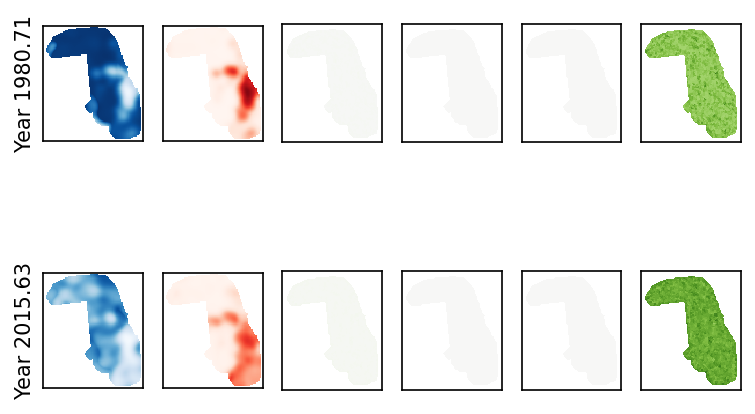

In [7]:
from data_processing import *
from pbnn import *
from dolfin_problems import *

def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        Dij, Dij_mesh, gammas = model.forward(sample['wb0'][None],
                                              sample['problem'].FctSpace,
                                              (sample['x'], sample['y']))
        Dij = Dij_mesh.reshape([4, -1])
        Dij = Dij.detach().cpu().numpy()
    
    if vmax is None:
        vmax = np.max(np.abs(Dij))
        print(f'Using vmax = {vmax:g}')

    for i in range(4):
        plot_mesh(ax[2+i], Dij[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij

dataset = CensusDataset('cook_IL',
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
model = DiagonalOnlyPBNN().to(device)
info = torch.load('data/dynamic_pbnn/DiagonalOnlyPBNN.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])

fig, ax = plt.subplots(2, 6, dpi=150)
plot(ax[0], dataset[0], model)
plot(ax[1], dataset[35], model);

$$ \dot{\phi_i } = \nabla \cdot (D_{ij} \nabla \phi_j + \Gamma_i \nabla^3 \phi_i ) + S_i $$

$$ \mathcal{L} = (\dot{\phi} - \dot{\hat{\phi}})^2 + \beta S_i^2 + \beta_{\Gamma} \Gamma^2 $$

Building dataset with constant housing in time
Using vmax = 0.648844
Si vmax = 0.0353981
Using vmax = 0.63409
Si vmax = 0.0321845


  0%|          | 0/40 [00:00<?, ?it/s]

Using vmax = 0.629123
Si vmax = 0.0451898
Target change after 40 years is: 0.112917
Predicted change after 40 years is: 0.164944
MSE after 40 years is: 0.0358055


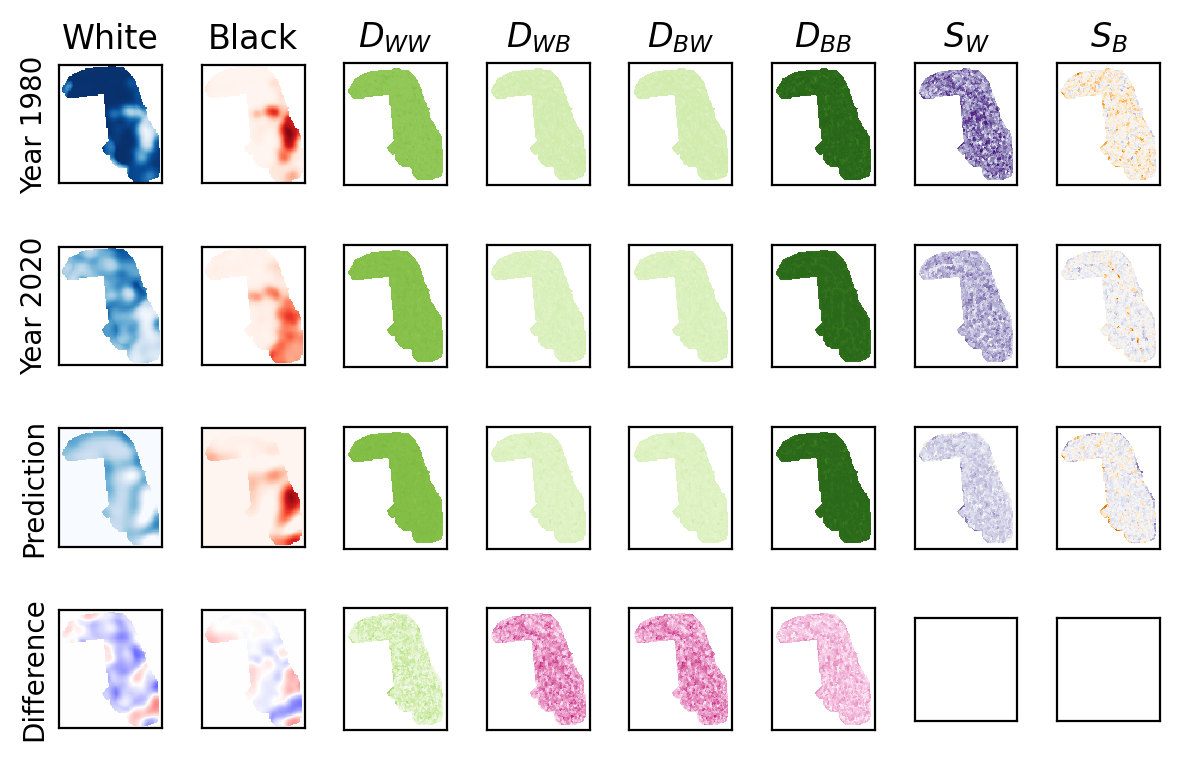

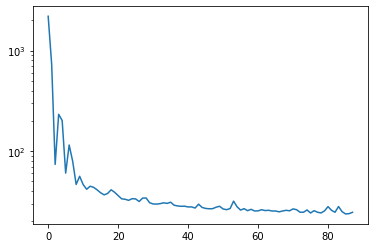

In [5]:
def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        params = model.forward(sample['wb0'][None],
                               sample['problem'].FctSpace,
                               (sample['x'], sample['y']))
        Dij = params['Dij'].detach().cpu().numpy()
        Si  = params['Si'].detach().cpu().numpy()
    
    if vmax is None:
        vmax = np.max(np.abs(Dij))
        print(f'Using vmax = {vmax:g}')

    for i in range(4):
        plot_mesh(ax[2+i], Dij[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
    
    vmax = np.max(np.abs(Si))
    print(f'Si vmax = {vmax:g}')
    for i in range(2):
        plot_mesh(ax[6+i], Si[i], dataset.mesh, cmap='PuOr', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij

from data_processing import *
from sourced_pbnn import *
from dolfin_problems import *

county = 'cook_IL'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=8728833
model = SourcedSymmetricPBNN().to(device)
info = torch.load(f'data/pipeline_{pipeline}/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(4, 8, dpi=200)

wb0, Dij0 = plot(ax[0], sample, model)
wb1, Dij1 = plot(ax[1], dataset[tmax], model)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Dij2 = plot(ax[2], sample, model)
ax[2,0].set_ylabel('Prediction')

print(f'Target change after {tmax} years is: {np.mean((wb1[:, mask]-wb0[:, mask])**2):g}')
print(f'Predicted change after {tmax} years is: {np.mean((wb2[:, mask]-wb0[:, mask])**2):g}')
print(f'MSE after {tmax} years is: {np.mean((wb2[:, mask]-wb1[:, mask])**2):g}')

diff = wb2 - wb1
vmax = 1
ax[3, 0].pcolormesh(sample['x'], sample['y'], diff[0], cmap='bwr', vmin=-vmax, vmax=vmax)
ax[3, 1].pcolormesh(sample['x'], sample['y'], diff[1], cmap='bwr', vmin=-vmax, vmax=vmax)

diff = Dij2 - Dij0
vmax = 3*np.std(diff)
for i in range(4):
    plot_mesh(ax[3, 2+i], diff[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
for a in ax[3]:
    a.set(aspect='equal', xticks=[], yticks=[])
ax[3, 0].set_ylabel('Difference')

ax[0,0].set_title('White')
ax[0,1].set_title('Black')
ax[0,2].set_title('$D_{WW}$')
ax[0,3].set_title('$D_{WB}$')
ax[0,4].set_title('$D_{BW}$')
ax[0,5].set_title('$D_{BB}$')
ax[0,6].set_title('$S_{W}$')
ax[0,7].set_title('$S_{B}$')

plt.tight_layout()

plt.figure()
plt.semilogy(info['val_loss'])

Building dataset with constant housing in time
Using vmax = 0.789321
Using vmax = 0.147258


  0%|          | 0/40 [00:00<?, ?it/s]

Using vmax = 0.476897
Target change after 40 years is: 0.112917
Predicted change after 40 years is: 0.00853706
MSE after 40 years is: 0.106099


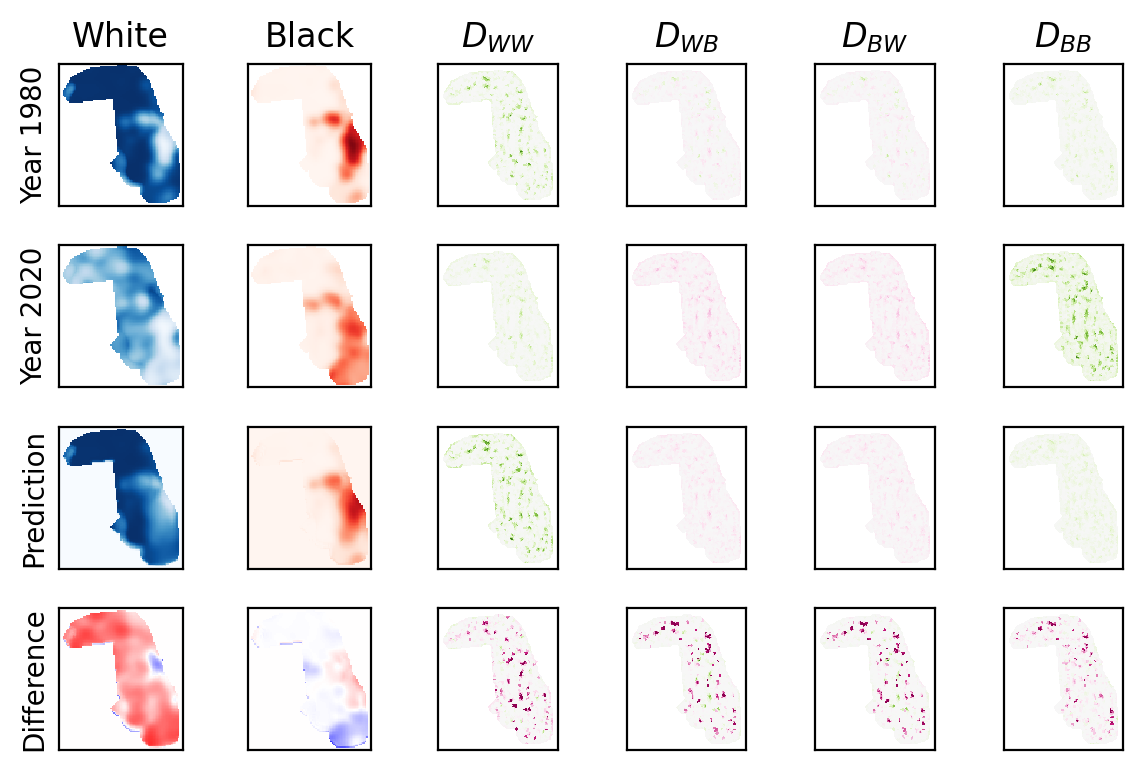

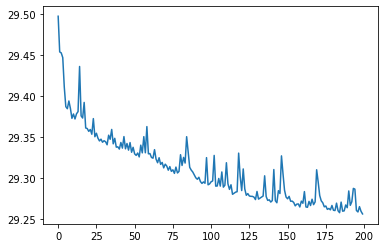

In [4]:
def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        _, Dij, gammas = model.forward(sample['wb0'][None],
                               sample['problem'].FctSpace,
                               (sample['x'], sample['y']))
        Dij = Dij.detach().cpu().numpy()
    
    if vmax is None:
        vmax = np.max(np.abs(Dij))
        print(f'Using vmax = {vmax:g}')

    for i in range(4):
        plot_mesh(ax[2+i], Dij[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'cook_IL'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

model = SymmetricCrossDiffusionPBNN().to(device)
info = torch.load(f'data/pipeline_8639583/pipeline_8639583_1/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(4, 6, dpi=200)

wb0, Dij0 = plot(ax[0], sample, model)
wb1, Dij1 = plot(ax[1], dataset[tmax], model)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Dij2 = plot(ax[2], sample, model)
ax[2,0].set_ylabel('Prediction')

print(f'Target change after {tmax} years is: {np.mean((wb1[:, mask]-wb0[:, mask])**2):g}')
print(f'Predicted change after {tmax} years is: {np.mean((wb2[:, mask]-wb0[:, mask])**2):g}')
print(f'MSE after {tmax} years is: {np.mean((wb2[:, mask]-wb1[:, mask])**2):g}')

diff = wb2 - wb1
vmax = 1
ax[3, 0].pcolormesh(sample['x'], sample['y'], diff[0], cmap='bwr', vmin=-vmax, vmax=vmax)
ax[3, 1].pcolormesh(sample['x'], sample['y'], diff[1], cmap='bwr', vmin=-vmax, vmax=vmax)

diff = Dij2 - Dij0
vmax = 3*np.std(diff)
for i in range(4):
    plot_mesh(ax[3, 2+i], diff[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
for a in ax[3]:
    a.set(aspect='equal', xticks=[], yticks=[])
ax[3, 0].set_ylabel('Difference')

ax[0,0].set_title('White')
ax[0,1].set_title('Black')
ax[0,2].set_title('$D_{WW}$')
ax[0,3].set_title('$D_{WB}$')
ax[0,4].set_title('$D_{BW}$')
ax[0,5].set_title('$D_{BB}$')

plt.tight_layout()

plt.figure()
plt.plot(info['val_loss'])

Building dataset with constant housing in time


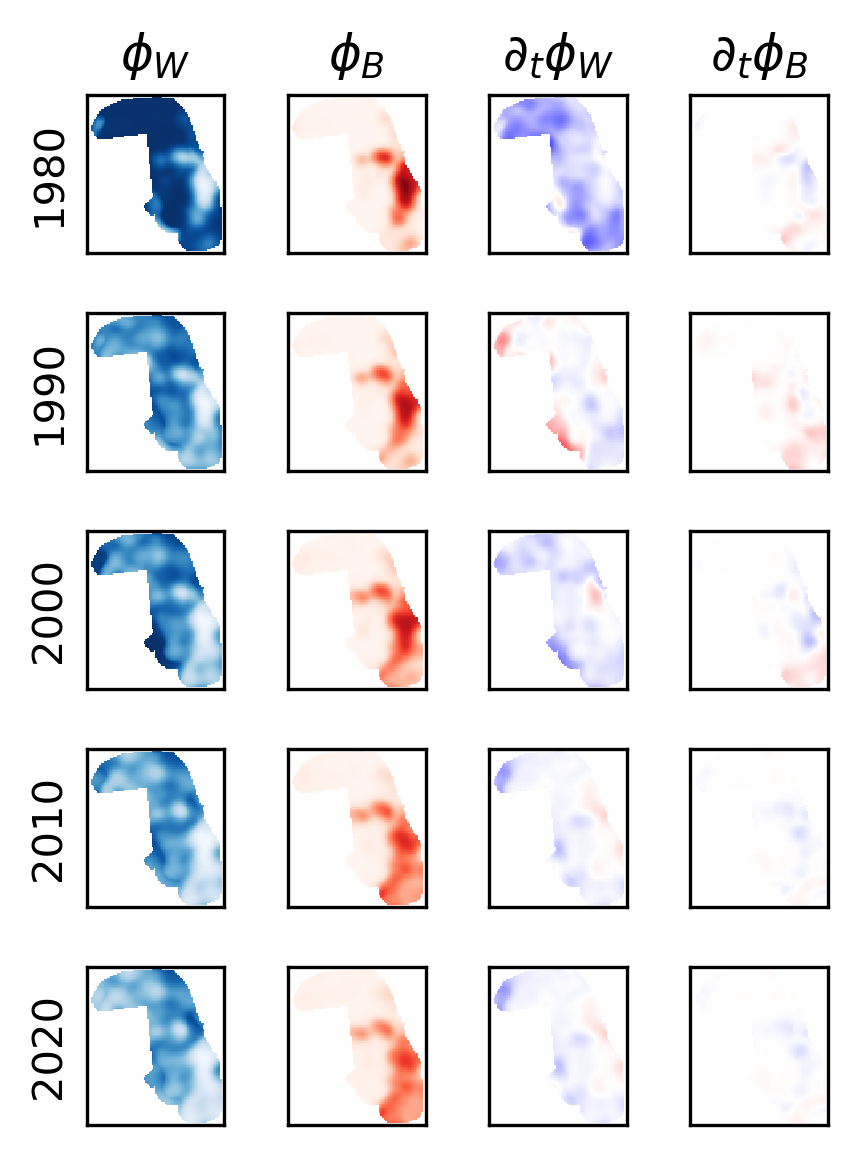

In [9]:
fig, ax = plt.subplots(5, 4, figsize=(3, 4), dpi=300)

county = 'cook_IL'
dataset = CensusDataset(county, housing_method='constant')
dataset.validate()

vmax = 0.1
for i in range(5):
    wb0 = dataset.wb(1980+i*10)
    wb1 = dataset.wb(1980+i*10+1)
    ax[i, 0].pcolormesh(dataset.x, dataset.y, wb0[0], vmin=0, vmax=1, cmap='Blues')
    ax[i, 1].pcolormesh(dataset.x, dataset.y, wb0[1], vmin=0, vmax=1, cmap='Reds')
    ax[i, 2].pcolormesh(dataset.x, dataset.y, wb1[0]-wb0[0], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i, 3].pcolormesh(dataset.x, dataset.y, wb1[1]-wb0[1], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i,0].set_ylabel(1980+i*10)

for a in ax.flatten():
    a.set(xticks=[], yticks=[], aspect='equal')
    
ax[0,0].set_title('$\phi_W$')
ax[0,1].set_title('$\phi_B$')
ax[0,2].set_title('$\partial_t \phi_W$')
ax[0,3].set_title('$\partial_t \phi_B$')
    
plt.tight_layout()